In [11]:
import requests

url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"
response = requests.get(url)
with open("titanic.csv", "wb") as f:
    f.write(response.content)


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('titanic.csv')


In [13]:
display(df.info())
display(df.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


None

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887,887,887.000000,887.000000,887.000000,887.00000
unique,NaN,NaN,887,2,NaN,NaN,NaN,NaN
top,NaN,NaN,Mr. Patrick Dooley,male,NaN,NaN,NaN,NaN
freq,NaN,NaN,1,573,NaN,NaN,NaN,NaN
mean,0.385569,2.305524,NaN,NaN,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,NaN,NaN,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,NaN,NaN,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,31.13750


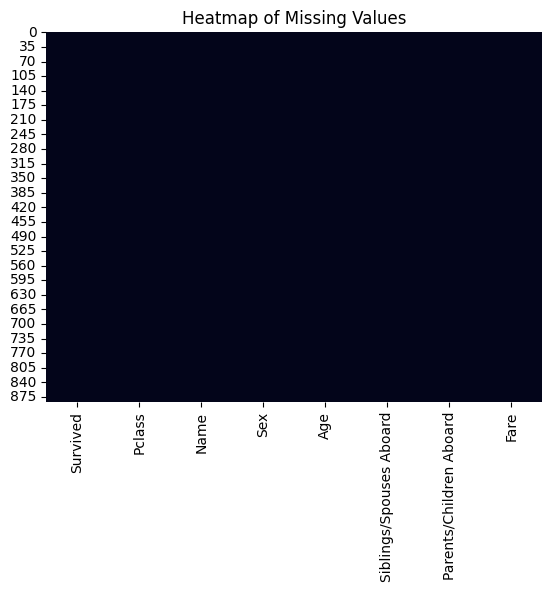

In [14]:
sns.heatmap(df.isnull(), cbar=False)
plt.title('Heatmap of Missing Values')
plt.show()


In [15]:
missing_cols = df.columns[df.isnull().any()]
for col in missing_cols:
    df[f'{col}_was_missing'] = df[col].isnull().astype(int)
    if df[col].dtype in [np.float64, np.int64]:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode().iloc[0], inplace=True)

In [16]:
Q1 = df['Fare'].quantile(0.25)
Q3 = df['Fare'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
fare_outliers = (df['Fare'] < lower) | (df['Fare'] > upper)

fare_min = df['Fare'].quantile(0.01)
fare_max = df['Fare'].quantile(0.99)
df['Fare'] = np.clip(df['Fare'], fare_min, fare_max)

df.to_csv('clean_v1.csv', index=False)

with open('decision_log.md', 'w') as f:
    f.write('- Missing numeric: median; missing categorical: mode; flag columns added.\n')
    f.write('- Fare outliers capped at 1st and 99th percentile.\n')
with open('data_card.md', 'w') as f:
    f.write('# Titanic Data Card\n')
    f.write('- Source: Titanic Kaggle dataset.\n')
    f.write('- Cleaned: missing, flagged, outliers capped.\n')


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

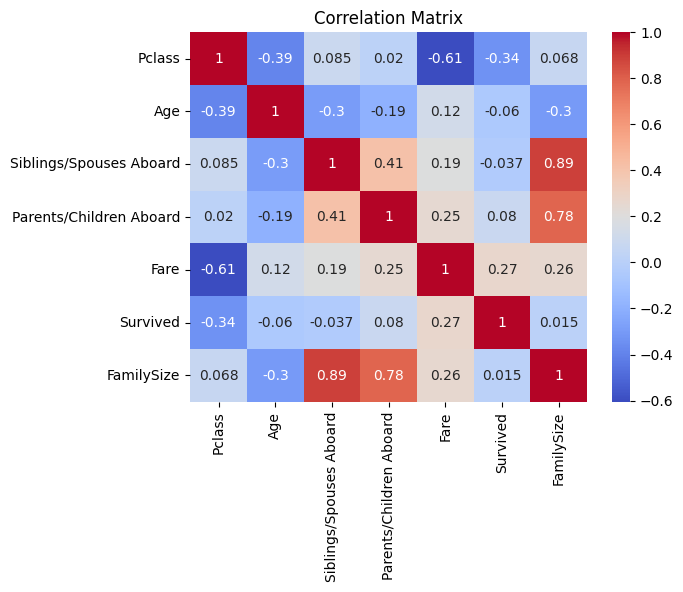

In [18]:
features = ['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']
target = 'Survived'
df = df[features + [target] + [col for col in df.columns if '_was_missing' in col]]

df['FamilySize'] = df['Siblings/Spouses Aboard'] + df['Parents/Children Aboard'] + 1

corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
drop_features = ['Siblings/Spouses Aboard', 'Parents/Children Aboard']
df.drop(columns=drop_features, inplace=True)


In [20]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(df, df[target]):
    train_set = df.iloc[train_idx].copy()
    test_set = df.iloc[test_idx].copy()

In [21]:
numeric_features_clf = ['Age', 'Fare', 'FamilySize']
categorical_features_clf = ['Pclass', 'Sex']
missing_features_clf = [col for col in train_set.columns if '_was_missing' in col]

In [22]:
preprocessor_clf = ColumnTransformer([
    ('num', StandardScaler(), numeric_features_clf),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_clf),
    ('missing', 'passthrough', missing_features_clf)
])

In [23]:
train_set.to_csv('train_set.csv', index=False)
test_set.to_csv('test_set.csv', index=False)
import joblib
pipeline_clf = Pipeline([
    ('preprocessor', preprocessor_clf)
])
joblib.dump(pipeline_clf, 'titanic_pipeline_clf.joblib')


['titanic_pipeline_clf.joblib']

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

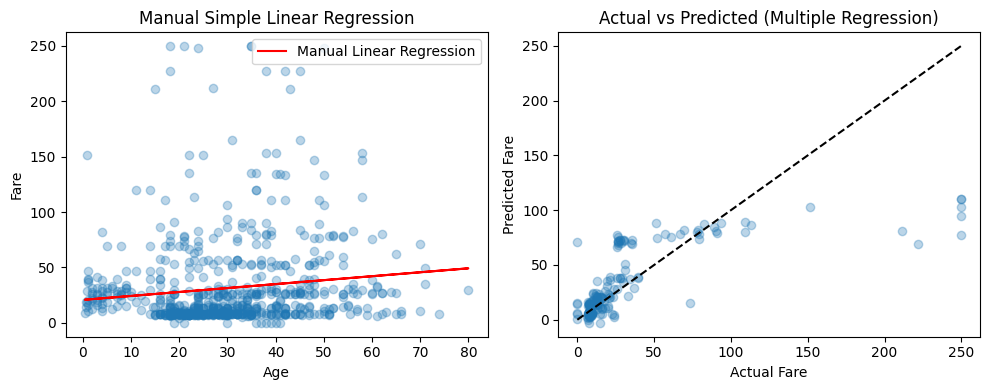

,Model,MSE,RMSE,R2
0,Manual Simple,1643.282314,40.537419,0.015476
1,Multiple LinReg,1176.014395,34.293066,0.509097
2,Polynomial,738.654158,27.178193,0.691664


In [25]:
reg_target = 'Fare'
reg_features = [col for col in train_set.columns if col not in [target, reg_target]]

X_train_age = train_set[['Age']].values
y_train_fare = train_set[reg_target].values
beta_1 = np.cov(X_train_age.T.flatten(), y_train_fare)[0,1] / np.var(X_train_age.T.flatten())
beta_0 = np.mean(y_train_fare) - beta_1 * np.mean(X_train_age)

y_pred_age = beta_0 + beta_1 * X_train_age.flatten()

mse_manual = mean_squared_error(y_train_fare, y_pred_age)
rmse_manual = np.sqrt(mse_manual)
r2_manual = r2_score(y_train_fare, y_pred_age)

X_train = train_set[reg_features]
X_test = test_set[reg_features]
y_train = train_set[reg_target]
y_test = test_set[reg_target]

numeric_features_reg = ['Age', 'FamilySize']
categorical_features_reg = ['Pclass', 'Sex']
missing_features_reg = [col for col in X_train.columns if '_was_missing' in col]


preprocessor_reg = ColumnTransformer([
    ('num', StandardScaler(), numeric_features_reg),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_reg),
    ('missing', 'passthrough', missing_features_reg)
])

X_train_prep = preprocessor_reg.fit_transform(X_train)
X_test_prep = preprocessor_reg.transform(X_test)


linreg = LinearRegression()
linreg.fit(X_train_prep, y_train)
y_pred_lr = linreg.predict(X_test_prep)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_prep)
X_test_poly = poly.transform(X_test_prep)

polyreg = LinearRegression()
polyreg.fit(X_train_poly, y_train)
y_pred_poly = polyreg.predict(X_test_poly)

mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X_train['Age'], y_train_fare, alpha=0.3)
plt.plot(X_train['Age'], y_pred_age, color='red', label='Manual Linear Regression')
plt.title('Manual Simple Linear Regression')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.title('Actual vs Predicted (Multiple Regression)')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.tight_layout()
plt.show()

results_table = pd.DataFrame({
    'Model': ['Manual Simple', 'Multiple LinReg', 'Polynomial'],
    'MSE': [mse_manual, mse_lr, mse_poly],
    'RMSE': [rmse_manual, rmse_lr, rmse_poly],
    'R2': [r2_manual, r2_lr, r2_poly]
})
results_table.to_csv('regression_results.csv', index=False)
display(results_table)